Reference: http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
from sklearn.metrics import accuracy_score
import seaborn as sns

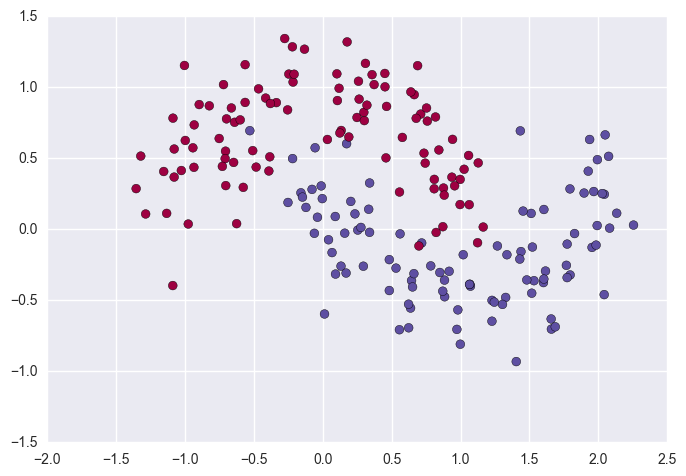

In [2]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

In [125]:
def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

## Define

\begin{align}
X \in \mathbb{R} ^{n\times d}, y \in \mathbb{R} ^ {n\times c}, W_1 \in \mathbb{R}^{d \times h}, b_1 \in \mathbb{R}^{1 \times h}, W_2 \in \mathbb{R}^{h \times c}, b_2 \in \mathbb{R}^{1 \times c} \\
\end{align}
\begin{align}
z_1&=XW_1+b_1 \\
a_1&=tanh(z_1) \\
z_2&=a_1W_2+b_2 \\
\hat{y}&=softmax(z_2)
\end{align}

Loss function is defined as the cross entropy of the true probability distribution $y$ and the predicted probabilty distribution $\hat{y}$.

\begin{align}
L&=-\sum_{i=1}^{n}\sum_{c \in C} y_{i,c}log\hat{y}_{i,c} \\
&=-\sum_{i}log\frac{e^{tanh(x_iW_1+b_1)W_{2,i}+b_{2,i}}}{\sum_{c}e^{tanh(x_iW_1+b_1)W_{2,c}+b_{2,c}}} \quad \text{where $W_{2,i}$ represents the weights of the true class}
\end{align}

Calculate gradient for each observation:   
For $W_2$

\begin{align}
\frac{\partial{L_i}}{\partial{W_{2,c}}}&=-[y_{i,c} tanh(x_iW_1+b_1)-\frac{e^{tanh(x_iW_1+b_1)W_{2,c}+b_{2,c}}}{\sum_{j \in C}e^{tanh(x_iW_1+b_1)W_{2,j}+b_{2,j}}}tanh(x_iW_1+b_1)] \\
&=tanh(x_iW_1+b_1)^T(\hat{y}_{i,c}-y_{i,c}) \\
\frac{\partial{L_i}}{\partial{W_2}}&=tanh(x_iW_1+b_1)^T(\hat{y}_i-y_i) \\
\end{align}

For $W_1$

\begin{align}
\frac{\partial{L_i}}{\partial{W_{1,h}}}&=-[W_{2,h,c}(1-tanh^2(x_iW_{1,h}+b_{1,h}))x_i - \sum_{j \in C}\hat{y}_jW_{2,h,j}(1-tanh^2(x_iW_{1,h}+b_{1,h}))x_i] \\
&=[\sum_{j \in C}(\hat{y}_j-y_j)W_{2,h,j}](1-tanh^2(x_iW_{1,h}+b_1))x_i \\
\frac{\partial{L_i}}{\partial{W_1}}&=x_i^T[(\hat{y}_i-y_i)W_2^T\circ(1-tanh^2(x_iW_1+b_1))]
\end{align}

For $b_2$

\begin{align}
\frac{\partial{L_i}}{\partial{b_2}}&=\hat{y}_i-y_i
\end{align}

For $b_1$

\begin{align}
\frac{\partial{L_i}}{\partial{b_1}}&=(\hat{y}_i-y_i)W_2^T\circ(1-tanh^2(x_iW_1+b_1))
\end{align}

Gradient for all observation:

\begin{align}
\frac{\partial{L}}{\partial{W_2}}&=tanh(XW_1+b_1)^T(\hat{y}-y) \\
\frac{\partial{L}}{\partial{W_1}}&=X^T[(\hat{y}-y)W_2^T\circ(1-tanh^2(XW_1+b_1))] \\
\frac{\partial{L}}{\partial{b_2}}&=\mathbf{1}^T(\hat{y}-y) \\
\frac{\partial{L}}{\partial{b_1}}&=\mathbf{1}^T[(\hat{y}-y)W_2^T\circ(1-tanh^2(XW_1+b_1))]
\end{align}

## Python Implementation

In [43]:
class NeuralNet:
    def __init__(self, h=2, epoch=50, epsilon=0.01, lambda_=0.01):
        self.h = h
        self.epoch = epoch
        self.epsilon = epsilon
        self.lambda_ = lambda_
        self.W2 = None
        self.W1 = None
        self.b2 = None
        self.b1 = None
    
    def fit(self, X, y):
        n = X.shape[0]
        d = X.shape[1]
        c = np.max(y) + 1
        W1 = np.random.randn(d, self.h) / d
        b1 = np.zeros(self.h)
        W2 = np.random.randn(self.h, c) / self.h
        b2 = np.zeros(c)
        
        for i in xrange(self.epoch):
            z1 = X.dot(W1)
            a1 = np.tanh(z1 + b1)
            z2 = a1.dot(W2) + b2
            exp_score = np.exp(z2)
            y_hat = exp_score / np.sum(exp_score, axis=1, keepdims=True)
            
            delta_1 = np.copy(y_hat)
            delta_1[range(n), y] -= 1
            delta_2 = delta_1.dot(W2.T) * (1 - np.power(a1, 2))

            dW1 = X.T.dot(delta_2)
            db1 = np.sum(delta_2, axis=0)
            dW2 = a1.T.dot(delta_1)
            db2 = np.sum(delta_1, axis=0)
            
            dW1 += self.lambda_ * W1
            dW2 += self.lambda_ * W2
            
            W1 -= self.epsilon * dW1
            b1 -= self.epsilon * db1
            W2 -= self.epsilon * dW2
            b2 -= self.epsilon * db2
            
#             if (i + 1) % 100 == 0 or i == 0:
#                 print 'step %d, loss: %s' % (i+1, 1.0/n*-np.sum(np.log(y_hat[range(n), y])) + self.lambda_/2 * (np.sum(W1**2) + np.sum(W2**2)))
        
        self.W1 = W1
        self.b1 = b1
        self.W2 = W2
        self.b2 = b2
    
    def predict(self, X):
        z1 = X.dot(self.W1)
        a1 = np.tanh(z1 + self.b1)
        z2 = a1.dot(self.W2) + self.b2
        exp_score = np.exp(z2)
        y_hat = exp_score / np.sum(exp_score, axis=1, keepdims=True)
        return np.argmax(y_hat, axis=1)

In [126]:
def plot_neural_net_decision_boundary(cls):
    hidden_layers = [1, 2, 3, 4, 5, 10, 20, 50]
    plt.figure(figsize=(10,14))
    plt.subplots_adjust(hspace=0.5)
    for i, h in enumerate(hidden_layers):
        nn = cls(h=h, epoch=1000)
        nn.fit(X,y)
        plt.subplot(4,2,i+1)
        plot_decision_boundary(nn.predict, X, y)
        plt.title("hiddle layer: %d" % h)

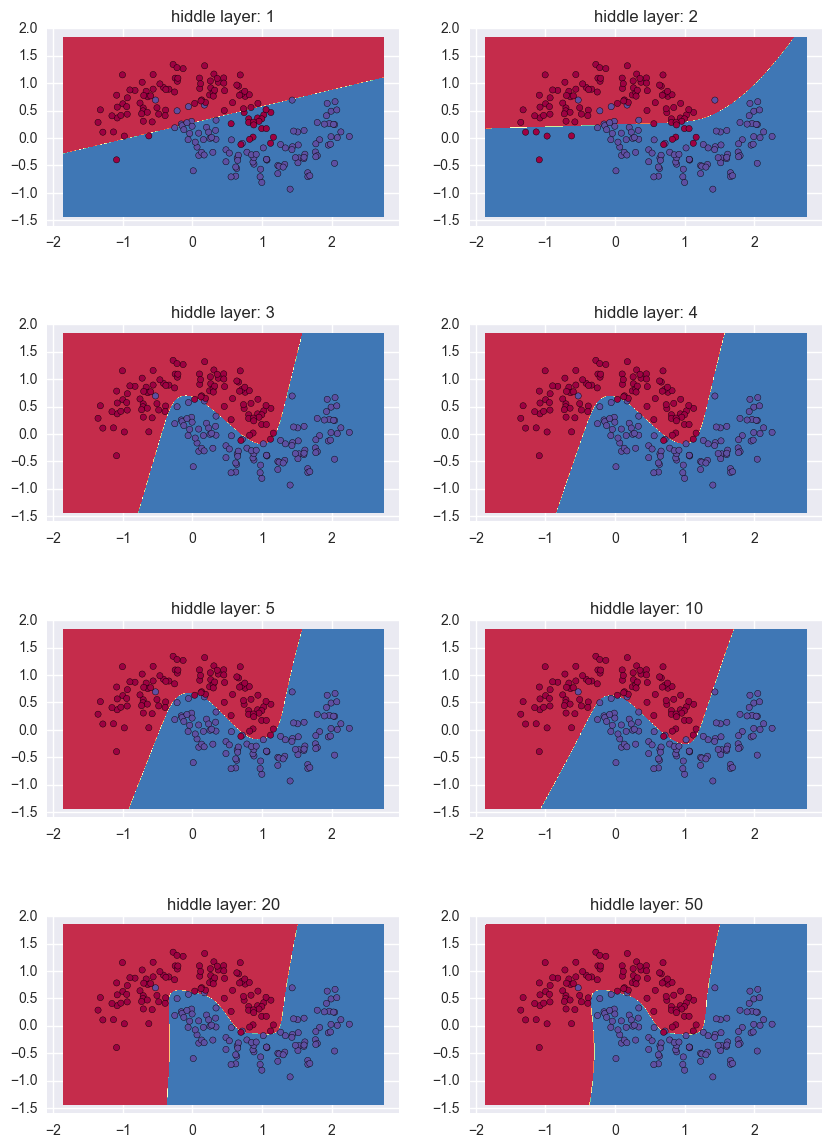

In [127]:
plot_neural_net_decision_boundary(NeuralNet)

## Tensorflow Implementation

In [ ]:
import tensorflow as tf
sess = tf.InteractiveSession()

In [128]:
class TensorflowNeuralNet:
    def __init__(self, h=2, epoch=50, epsilon=0.01, lambda_=0.01):
        self.h = h
        self.epoch = epoch
        self.epsilon = epsilon
        self.lambda_ = lambda_
        self.W2 = None
        self.W1 = None
        self.b2 = None
        self.b1 = None
    
    def fit(self, X, y):
        n = X.shape[0]
        d = X.shape[1]
        c = np.max(y) + 1
        y = self._reshape_y(y)

        tf_X = tf.placeholder(tf.float32, [None, d])
        tf_y = tf.placeholder(tf.float32, [None, c])
        W1 = tf.Variable(tf.random_normal([d, self.h])/d)
        b1 = tf.Variable(tf.zeros(self.h))
        W2 = tf.Variable(tf.random_normal([self.h, c])/self.h)
        b2 = tf.Variable(tf.zeros(c))

        z1 = tf.matmul(tf_X, W1)
        a1 = tf.tanh(z1 + b1)
        z2 = tf.matmul(a1, W2) + b2
        y_hat = tf.nn.softmax(z2)
        
        delta_1 = y_hat - tf_y
        delta_2 = tf.matmul(delta_1, tf.transpose(W2)) * tf.sub(1.0, tf.pow(a1, 2))
        
        dW1 = tf.matmul(tf.transpose(tf_X), delta_2)
        db1 = tf.reduce_sum(delta_2, reduction_indices=0)
        dW2 = tf.matmul(tf.transpose(a1), delta_1)
        db2 = tf.reduce_sum(delta_1, reduction_indices=0)
        
        steps = [
            tf.assign(W1, W1 - self.epsilon * (dW1 + self.lambda_ * W1)),
            tf.assign(b1, b1 - self.epsilon * db1),
            tf.assign(W2, W2 - self.epsilon * (dW2 + self.lambda_ * W2)),
            tf.assign(b2, b2 - self.epsilon * db2)
        ]
        sess.run(tf.initialize_all_variables())
        for i in xrange(self.epoch):
            sess.run(steps, feed_dict={tf_X: X, tf_y: y})
        
        self.W1 = W1
        self.b1 = b1
        self.W2 = W2
        self.b2 = b2
    
    def predict(self, X):
        tf_X = tf.placeholder(tf.float32, [None, X.shape[1]])
        z1 = tf.matmul(tf_X, self.W1)
        a1 = tf.tanh(z1 + self.b1)
        z2 = tf.matmul(a1, self.W2) + self.b2
        y_hat = tf.argmax(tf.nn.softmax(z2), dimension=1)
        return sess.run(y_hat, feed_dict={tf_X: X})

    def _reshape_y(self, y):
        new_y = np.zeros((y.shape[0], np.max(y)+1))
        new_y[range(len(y)), y] = 1
        return new_y

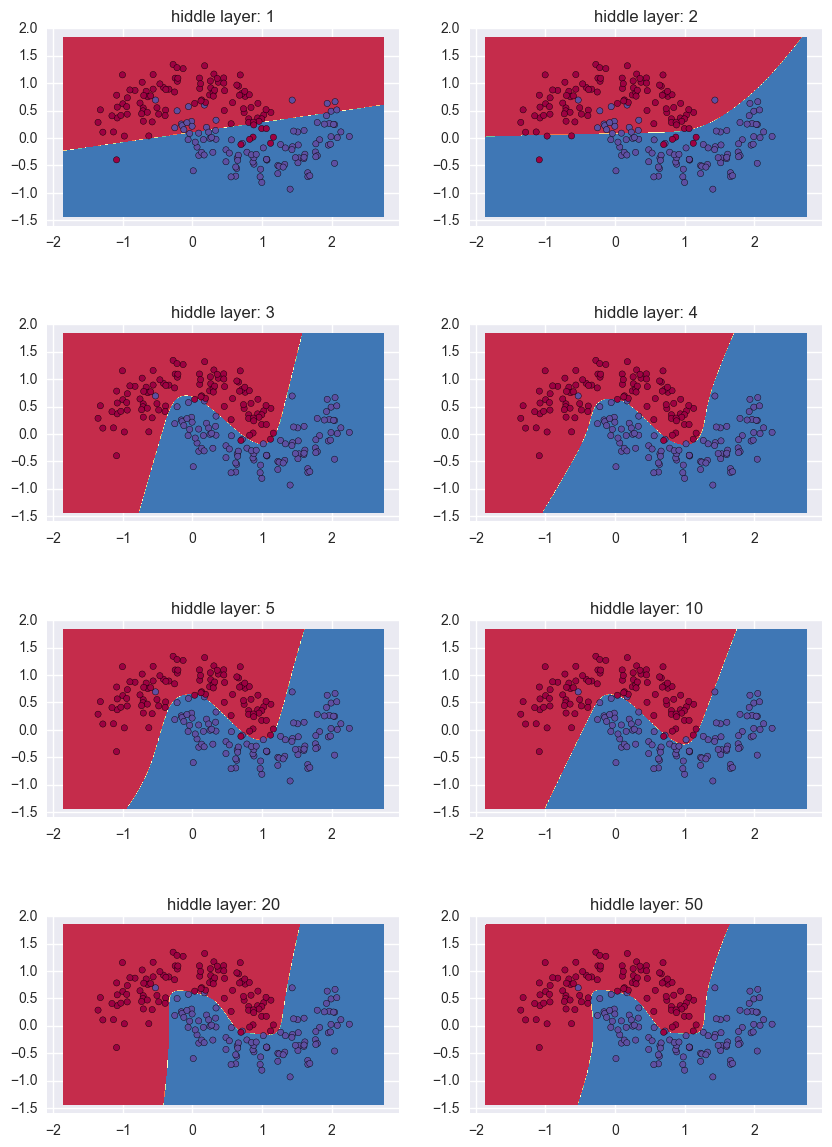

In [129]:
plot_neural_net_decision_boundary(TensorflowNeuralNet)